In [1]:
# compute_pca_vectors_svd.py
import os
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.align import AverageStructure
from MDAnalysis.coordinates.PDB import PDBWriter

# ====== CONFIG ======
PDB_IN = r"C:\Users\edupr\Downloads\PAPERIQ\CF3\modvector\replicamutSLA07.pdb"
OUTDIR = r"C:\Users\edupr\Downloads\PAPERIQ\CF3\modvector\pca_out"
SELECT = "name CA"     # use a mesma seleção depois no PyMOL
DISPLACEMENT = 3.0     # Å, magnitude do deslocamento ao longo do PC
WRITE_MODES_STACK = True

os.makedirs(OUTDIR, exist_ok=True)

# ====== Carrega ======
u = mda.Universe(PDB_IN, format="PDB")
sel = u.select_atoms(SELECT)
n_sel = sel.n_atoms
n_frames = len(u.trajectory)

# ====== Alinhamento (remove trans/rot) ======
# Alinha todos os frames ao frame 0 usando a seleção
align.AlignTraj(u, u, select=SELECT, in_memory=True).run()

# ====== Monta matriz de dados X (frames x 3*n_sel) ======
X = np.empty((n_frames, 3 * n_sel), dtype=np.float64)
for i, ts in enumerate(u.trajectory):
    coords = sel.positions.astype(np.float64)        # (n_sel, 3)
    X[i, :] = coords.reshape(-1)                     # (3*n_sel,)

# ====== Média e centralização ======
mean_vec = X.mean(axis=0)                            # (3*n_sel,)
Xc = X - mean_vec

# ====== PCA via SVD ======
# Xc = U S V^T -> PCs (direções) = colunas de V = linhas de V^T
# Pegamos as 2 primeiras direções para PC1 e PC2
U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
eig_flat_PC1 = Vt[0, :].copy()                       # (3*n_sel,)
eig_flat_PC2 = Vt[1, :].copy()

# Normaliza para comprimentos comparáveis (opcional mas recomendado)
def normalize(v):
    n = np.linalg.norm(v)
    return v / n if n > 0 else v

eig_flat_PC1 = normalize(eig_flat_PC1)
eig_flat_PC2 = normalize(eig_flat_PC2)

mean_coords_sel = mean_vec.reshape(n_sel, 3)         # (n_sel, 3)
pc1_vec = eig_flat_PC1.reshape(n_sel, 3)             # (n_sel, 3)
pc2_vec = eig_flat_PC2.reshape(n_sel, 3)

# ====== Estrutura média de TODOS os átomos para injeção ======
avg = AverageStructure(u, select="all", ref_frame=0).run()
u_mean = avg.results.universe
all_atoms_mean = u_mean.atoms
sel_mean = u_mean.select_atoms(SELECT)

# ====== Função para escrever estados deslocados ======
def write_state_from_pc(sel_atoms_mean, all_atoms_mean, base_coords_sel, disp_vec, scale, out_path):
    new_coords_sel = base_coords_sel + scale * disp_vec
    coords_all = all_atoms_mean.positions.copy()
    coords_all[sel_atoms_mean.indices] = new_coords_sel
    all_atoms_mean.positions = coords_all
    with PDBWriter(out_path, multiframe=False) as W:
        W.write(all_atoms_mean)

# ====== Escreve mean, ±PC1, ±PC2 ======
mean_pdb = os.path.join(OUTDIR, "mean_CA_injected.pdb")
write_state_from_pc(sel_mean, all_atoms_mean, mean_coords_sel, pc1_vec, 0.0, mean_pdb)

pc1m = os.path.join(OUTDIR, "pc1_minus.pdb")
pc1p = os.path.join(OUTDIR, "pc1_plus.pdb")
write_state_from_pc(sel_mean, all_atoms_mean, mean_coords_sel, pc1_vec, -DISPLACEMENT, pc1m)
write_state_from_pc(sel_mean, all_atoms_mean, mean_coords_sel, pc1_vec, +DISPLACEMENT, pc1p)

pc2m = os.path.join(OUTDIR, "pc2_minus.pdb")
pc2p = os.path.join(OUTDIR, "pc2_plus.pdb")
write_state_from_pc(sel_mean, all_atoms_mean, mean_coords_sel, pc2_vec, -DISPLACEMENT, pc2m)
write_state_from_pc(sel_mean, all_atoms_mean, mean_coords_sel, pc2_vec, +DISPLACEMENT, pc2p)

# ====== (opcional) empilha em um único PDB com MODELs ======
if WRITE_MODES_STACK:
    stack = os.path.join(OUTDIR, "modes_for_pymol.pdb")
    files = [mean_pdb, pc1m, pc1p, pc2m, pc2p]
    with open(stack, "w") as outfh:
        for i, f in enumerate(files, start=1):
            outfh.write(f"MODEL     {i}\n")
            with open(f, "r") as fh:
                for line in fh:
                    if line.startswith(("ATOM","HETATM","TER")):
                        outfh.write(line)
            outfh.write("ENDMDL\n")

print("OK! Gerados em:", OUTDIR)
print(" - mean_CA_injected.pdb")
print(" - pc1_minus/pc1_plus, pc2_minus/pc2_plus")
print(" - modes_for_pymol.pdb (MODEL 1=mean, 2=-PC1, 3=+PC1, 4=-PC2, 5=+PC2)")

C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\topology\PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\core\universe.py:743: UserWarning: Reader has no dt information, set to 1.0 ps
  dt=self.traje

OK! Gerados em: C:\Users\edupr\Downloads\PAPERIQ\CF3\modvector\pca_out
 - mean_CA_injected.pdb
 - pc1_minus/pc1_plus, pc2_minus/pc2_plus
 - modes_for_pymol.pdb (MODEL 1=mean, 2=-PC1, 3=+PC1, 4=-PC2, 5=+PC2)


C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\coordinates\PDB.py:777: UserWarning: Unit cell dimensions not found. CRYST1 record set to unitary values.
  warnings.warn("Unit cell dimensions not found. "
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\coordinates\PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\coordinates\PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"


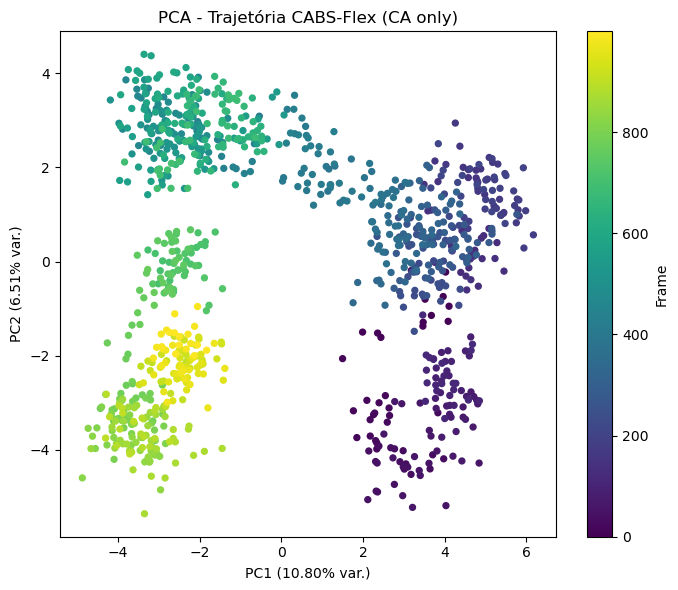

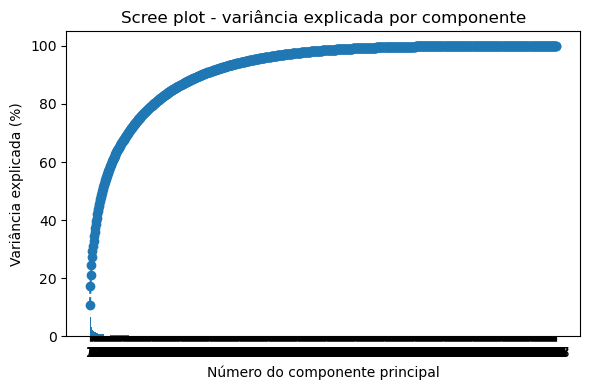

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc27VH8.svg
C:\Users\edupr\pca_scree.svg7VH8
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [2]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\Apo7vh8\\output_pdbs\\trajectories\\replica0.pdb"   # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc27VH8.svg"
out_scree_svg   = out_dir / "pca_scree.svg7VH8"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\topology\PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\analysis\base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[id

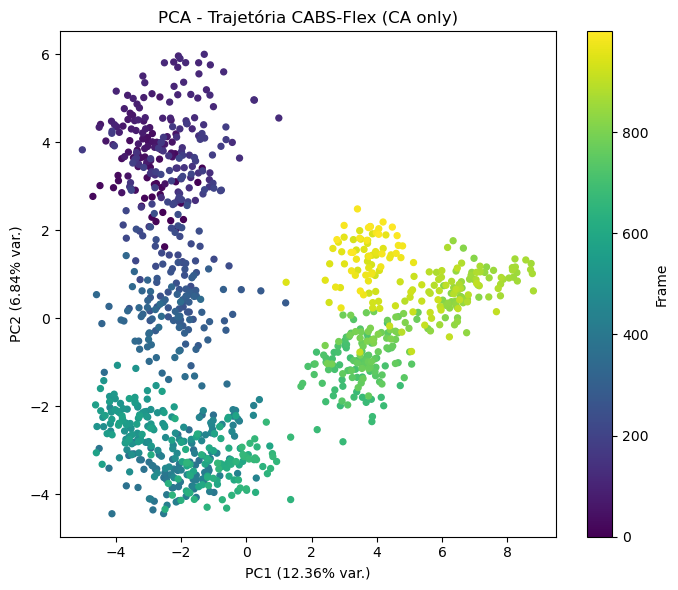

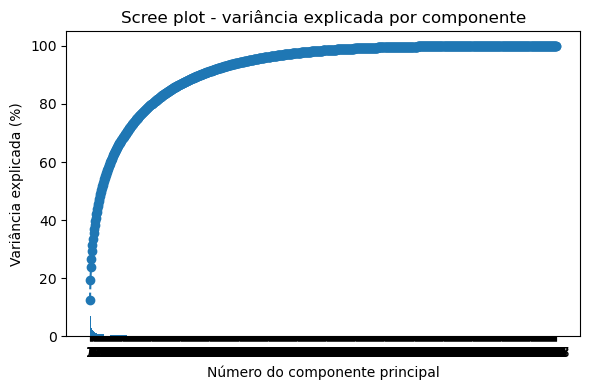

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2.svg
C:\Users\edupr\pca_scree.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\analysis\pca.py:350: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [1]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\CF3\\RedmproCF\\output_pdbs\\trajectories\\replica.pdb"   # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2.svg"
out_scree_svg   = out_dir / "pca_scree.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")


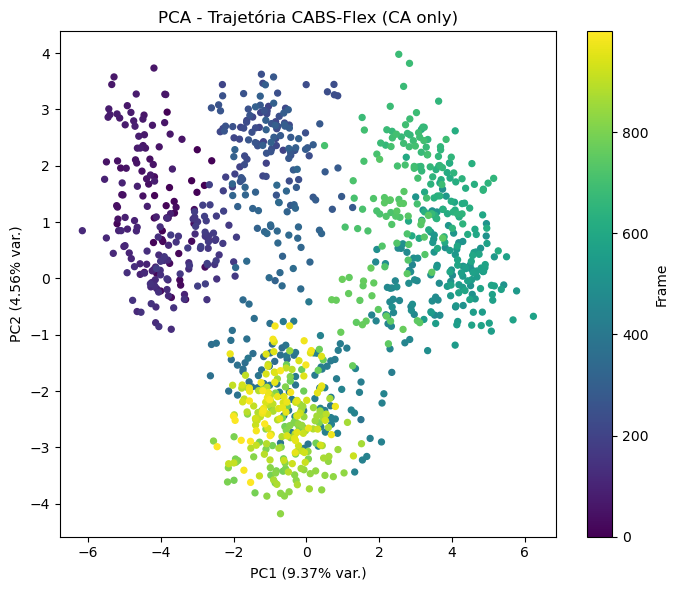

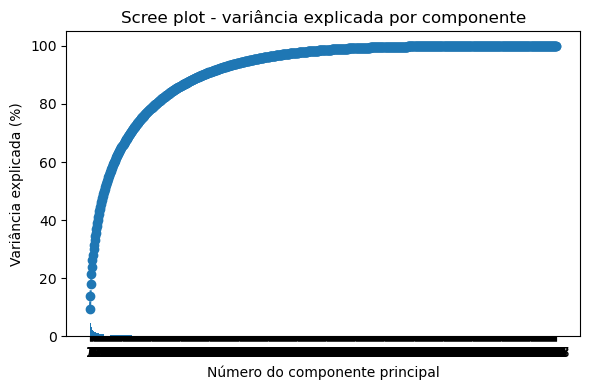

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2SLC.svg
C:\Users\edupr\pca_screeSLC.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [3]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\SLCmproCF\\output_pdbs\\trajectories\\replica2.pdb"   # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2SLC.svg"
out_scree_svg   = out_dir / "pca_screeSLC.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

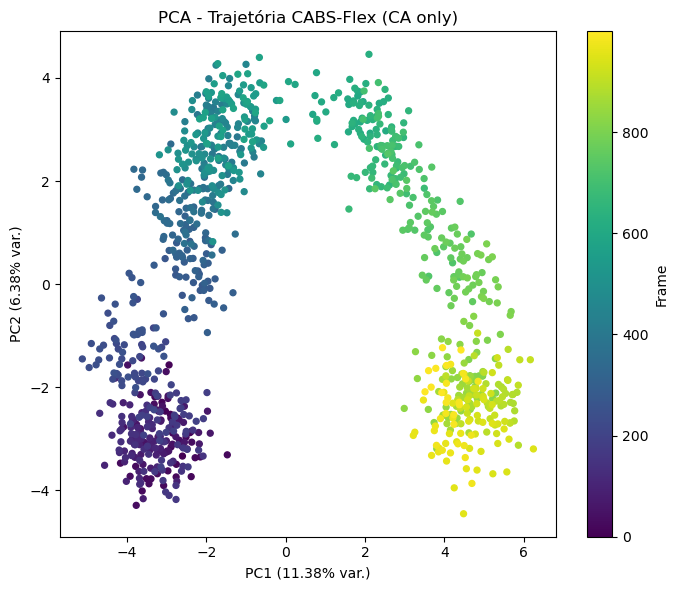

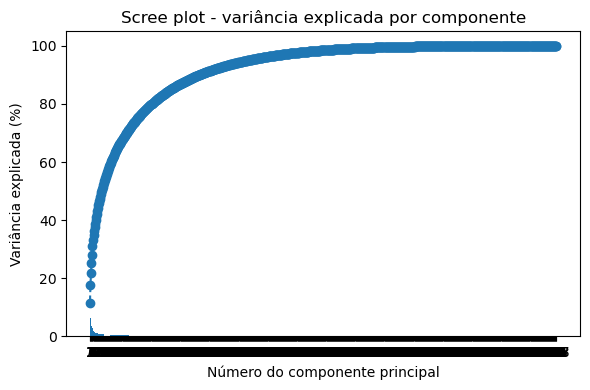

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2SLCd.svg
C:\Users\edupr\pca_screeSLCd.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [4]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\SLCdMpro\\output_pdbs\\trajectories\\replica3.pdb"   # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2SLCd.svg"
out_scree_svg   = out_dir / "pca_screeSLCd.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

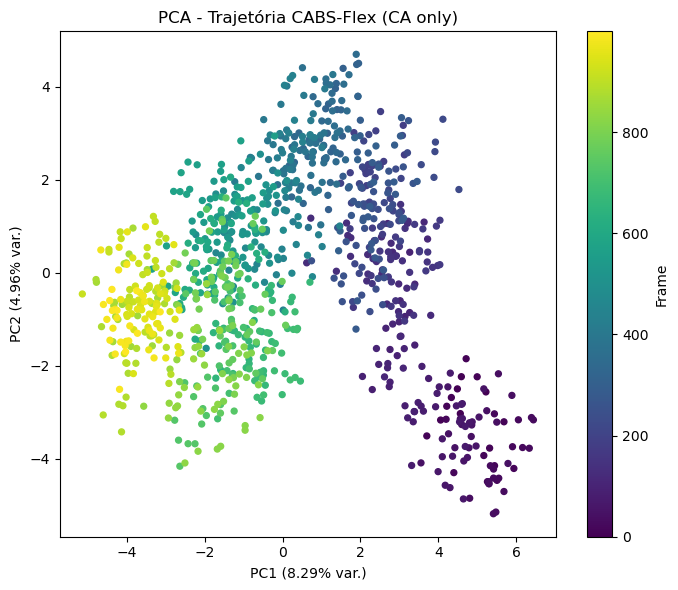

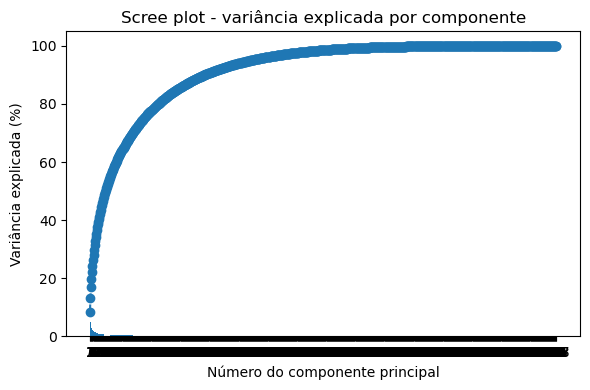

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2SLA07.svg
C:\Users\edupr\pca_screeSLA07.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [5]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\SLA07mpro\\output_pdbs\\trajectories\\replica4.pdb"   # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2SLA07.svg"
out_scree_svg   = out_dir / "pca_screeSLA07.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

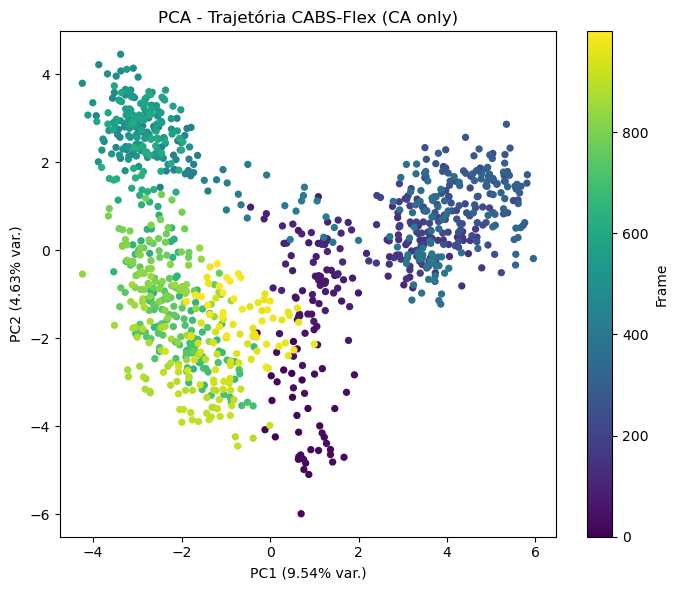

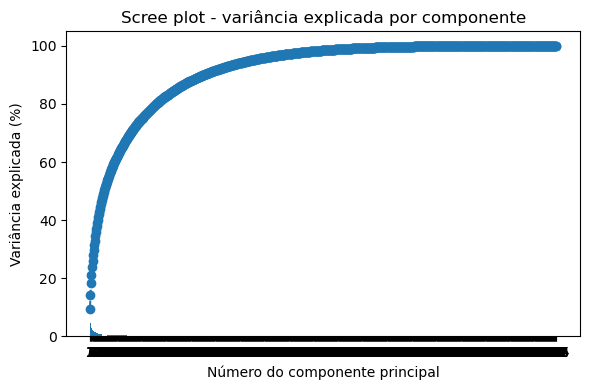

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc27UUP.svg
C:\Users\edupr\pca_scree7UUP.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [6]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\mutapo\\output_pdbs\\trajectories\\replica7uup.pdb"  # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc27UUP.svg"
out_scree_svg   = out_dir / "pca_scree7UUP.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

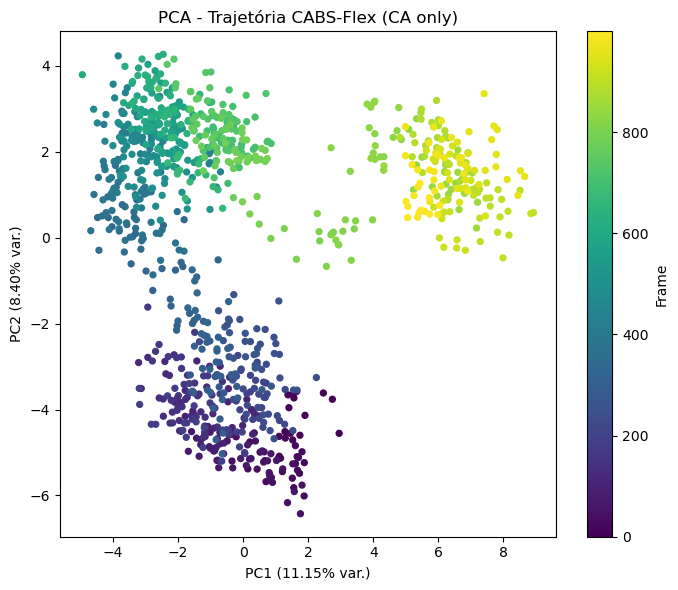

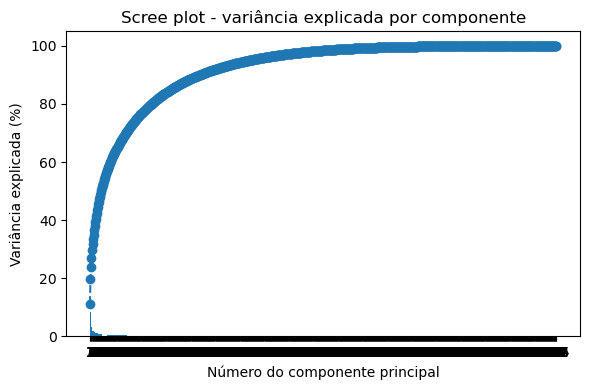

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2mutred.svg
C:\Users\edupr\pca_screemutred.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [7]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\mutred\\output_pdbs\\trajectories\\replicamutred.pdb" # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2mutred.svg"
out_scree_svg   = out_dir / "pca_screemutred.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

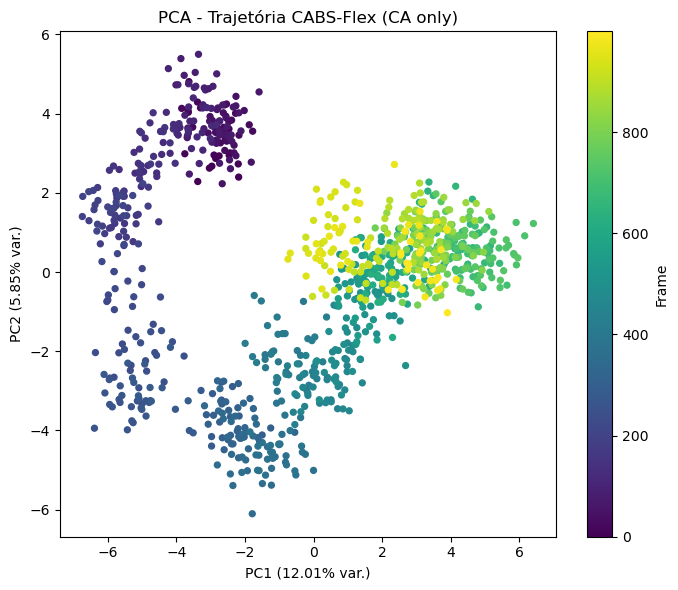

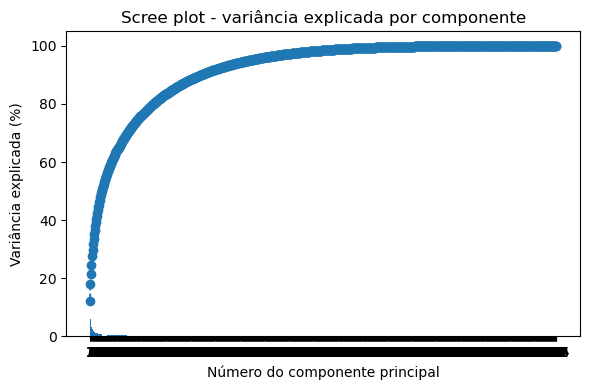

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2mutslc.svg
C:\Users\edupr\pca_screemutslc.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [8]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\mutSLC\\output_pdbs\\trajectories\\replicamutSLC.pdb" # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2mutslc.svg"
out_scree_svg   = out_dir / "pca_screemutslc.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

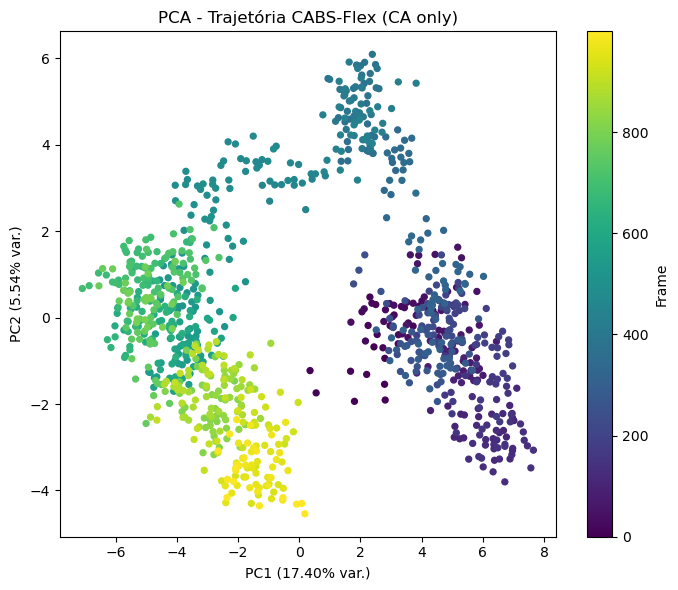

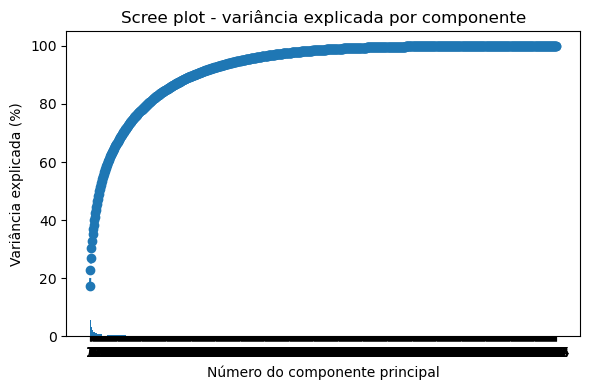

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2mutslcD.svg
C:\Users\edupr\pca_screemutslcD.svg
C:\Users\edupr\pca_eigenvalues.csv
C:\Users\edupr\pca_components.npy


In [9]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\mutSLCd\\output_pdbs\\trajectories\\replicaSLCd.pdb" # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2mutslcD.svg"
out_scree_svg   = out_dir / "pca_screemutslcD.svg"
out_eig_csv     = out_dir / "pca_eigenvalues.csv"
out_components  = out_dir / "pca_components.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")

C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\topology\PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "
C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\analysis\base.py:542: UserWarning: Reader has no dt information, set to 1.0 ps
  self.times[id

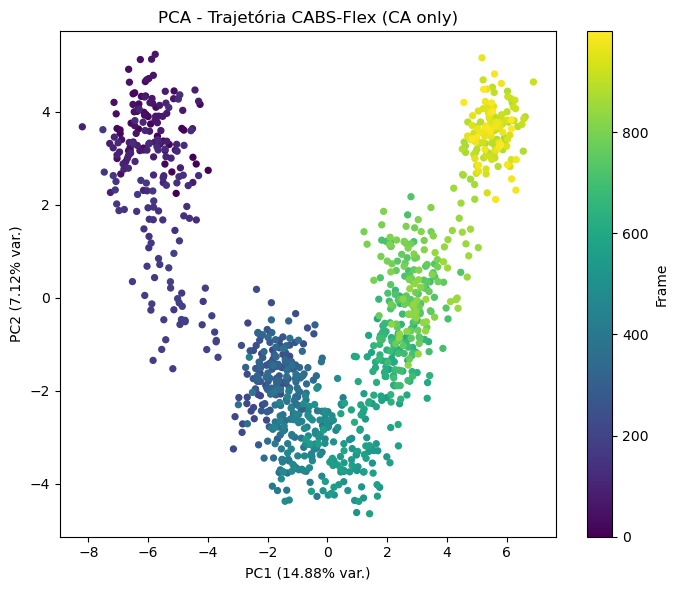

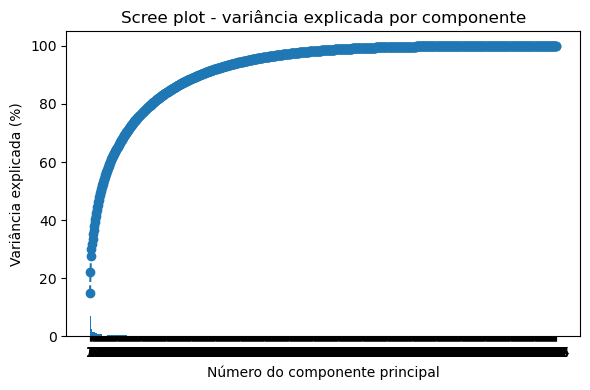

Arquivos gerados:
C:\Users\edupr\pca_pc1_pc2mutsla07VF.svg
C:\Users\edupr\pca_screemutsla07VF.svg
C:\Users\edupr\pca_eigenvaluesVF.csv
C:\Users\edupr\pca_componentsVF.npy


C:\Users\edupr\anaconda3\envs\eduardo\lib\site-packages\MDAnalysis\analysis\pca.py:350: DeprecationWarning: The `p_components` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.p_components` instead.
  warnings.warn(wmsg, DeprecationWarning)


In [2]:
# PCA_MDAnalysis_corrected.py
import MDAnalysis as mda
from MDAnalysis.analysis import pca as mda_pca
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import os

# ===== CONFIGURAÇÃO =====
trajeto_pdb = "C:\\Users\\edupr\\Downloads\\PAPERIQ\\CF3\\mutSLA07\\output_pdbs\\trajectories\\replicamutSLA07.pdb" # <-- seu arquivo PDB com 1000 frames
selecionar = "protein and name CA"  # seleção para PCA
out_dir = Path(".")                 # pasta de saída
out_dir.mkdir(parents=True, exist_ok=True)

out_scatter_svg = out_dir / "pca_pc1_pc2mutsla07VF.svg"
out_scree_svg   = out_dir / "pca_screemutsla07VF.svg"
out_eig_csv     = out_dir / "pca_eigenvaluesVF.csv"
out_components  = out_dir / "pca_componentsVF.npy"  # componentes principais em binário numpy

# ===== CARREGAR UNIVERSE =====
# Para um PDB contendo múltiplos MODELs/MODELs concatenados, basta passar o arquivo
u = mda.Universe(trajeto_pdb)

# ===== CONFIGURAR E RODAR PCA =====
# Atenção: PASSAR O Universe ao PCA (não o AtomGroup)
pca_analysis = mda_pca.PCA(u, select=selecionar, align=True)  # alinha ao primeiro frame por padrão
pca_analysis.run()

# ===== PROJEÇÃO (frames x n_components) =====
# transform aceita um AtomGroup e o número de componentes
atomgroup = u.select_atoms(selecionar)
proj = pca_analysis.transform(atomgroup, n_components=2)  # shape = (n_frames, 2)

# ===== OBTER VARIÂNCIA (robusto a mudanças de atributo entre versões) =====
variance = getattr(pca_analysis, "variance", None)
if variance is None:
    results = getattr(pca_analysis, "results", None)
    if results is not None:
        variance = getattr(results, "variance", None)
if variance is None:
    raise AttributeError("Não foi possível recuperar 'variance' do objeto PCA. Verifique a versão do MDAnalysis.")

# ===== PLOT PC1 vs PC2 =====
plt.figure(figsize=(7, 6))
sc = plt.scatter(proj[:, 0], proj[:, 1], c=np.arange(len(proj)), cmap="viridis", s=18)
plt.xlabel(f"PC1 ({(variance[0]/variance.sum())*100:.2f}% var.)")
plt.ylabel(f"PC2 ({(variance[1]/variance.sum())*100:.2f}% var.)")
plt.title("PCA - Trajetória CABS-Flex (CA only)")
cbar = plt.colorbar(sc)
cbar.set_label("Frame")
plt.tight_layout()
plt.savefig(out_scatter_svg, format="svg", dpi=300)
plt.show()

# ===== SCREE / VARIÂNCIA EXPLICADA =====
explained_ratio = variance / variance.sum()
cumulated = np.cumsum(explained_ratio)

plt.figure(figsize=(6, 4))
n = len(explained_ratio)
x = np.arange(1, n+1)
plt.bar(x, explained_ratio*100)
plt.plot(x, cumulated*100, marker='o', linestyle='--')
plt.xlabel("Número do componente principal")
plt.ylabel("Variância explicada (%)")
plt.title("Scree plot - variância explicada por componente")
plt.xticks(x)
plt.tight_layout()
plt.savefig(out_scree_svg, format="svg", dpi=300)
plt.show()

# ===== SALVAR AUTOVALORES E COMPONENTES =====
np.savetxt(out_eig_csv, variance, delimiter=",", header="eigenvalue", comments="")
# componentes principais (cada coluna = componente)
p_components = getattr(pca_analysis, "p_components", None)
if p_components is None and getattr(pca_analysis, "results", None) is not None:
    p_components = getattr(pca_analysis.results, "p_components", None)
if p_components is not None:
    np.save(out_components, p_components)
else:
    # se não existir p_components, avisa mas não falha
    print("Aviso: não foi possível recuperar p_components (variação entre versões do MDAnalysis).")

print("Arquivos gerados:")
print(os.path.abspath(out_scatter_svg))
print(os.path.abspath(out_scree_svg))
print(os.path.abspath(out_eig_csv))
print(os.path.abspath(out_components) if p_components is not None else "(componentes não salvos)")